# MSC_DA_CA1_Semester_2:
# A Comparative Analysis of CNN, MobileNetV2, and VGG-16 for Potato Leaf Disease Classification: A Big Data Approach Using Hadoop and Apache Spark

**Name:**
Madina Sagatova

**Student ID:**
2021255

**Student email:**
2021255@student.cct.ie

**Programme Title:**
MSc in Data Analytics

***************
Data Source: [Kaggle: Potato Plant Diseases Data](https://www.kaggle.com/datasets/hafiznouman786/potato-plant-diseases-data)

Licence: [CC0: Public Domain](https://creativecommons.org/publicdomain/zero/1.0/)
***************

# Imports
*********

In [1]:
# Install necessary libraries
#!pip install hdfs
#!pip install torch
#!pip install torchvision
#pip install torchviz
#!pip install torchsummary

In [4]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from hdfs import InsecureClient
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
import torch.optim as optim
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_extract, col
from torchsummary import summary
from torchviz import make_dot
from IPython.display import Image

# Initialize Spark Session
****

In [5]:
# Create a Spark session 
spark = SparkSession.builder \
       .appName('PotatoLeafDiseas') \
       .config('spark.executor.memory', '8g') \
       .config('spark.driver.memory', '8g') \
       .getOrCreate()
spark

24/10/09 08:42:31 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# Load Images from HDFS
*****

In [6]:
# Loading the images from HDFS 
data = spark.read.format('image').load('hdfs://localhost:9000/user1/potato_disease/*').limit(2000)
data.coalesce(4)
# Displaying schema to ensure the data is loaded correctly 
data.printSchema()

# Show some sample data
data.show()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



+--------------------+
|               image|
+--------------------+
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
+--------------------+
only showing top 20 rows



In [7]:
# Extract images and labels
data = data.withColumn('label', regexp_extract(col('image.origin'), 'potato_disease/([^/]+)', 1))
data.select('image.origin', 'label').show(10)

+--------------------+--------------------+
|              origin|               label|
+--------------------+--------------------+
|hdfs://localhost:...|Potato___Early_bl...|
|hdfs://localhost:...|Potato___Early_bl...|
|hdfs://localhost:...|    Potato___healthy|
|hdfs://localhost:...|    Potato___healthy|
|hdfs://localhost:...|    Potato___healthy|
|hdfs://localhost:...|Potato___Early_bl...|
|hdfs://localhost:...|    Potato___healthy|
|hdfs://localhost:...|    Potato___healthy|
|hdfs://localhost:...|Potato___Early_bl...|
|hdfs://localhost:...|    Potato___healthy|
+--------------------+--------------------+
only showing top 10 rows



# Define Dataset Class
****

In [8]:
class PotatoLeafDataset(Dataset):
    def __init__(self, spark_df, transform=None):
        # Initialize transformation function & empty lists for images and labels
        self.transform = transform
        self.image_data = []
        self.labels = []
        
        # define the mapping of the class names to indices
        self.label_mapping = {
            'Potato___Early_blight': 0,
            'Potato___Late_blight': 1,
            'Potato___healthy': 2
        }
        # Iterate over each row in the Spark DF
        for row in spark_df.collect():
            # Load imgs from the binary data
            image = np.frombuffer(row['image']['data'], dtype=np.uint8).reshape(
                        (row['image']['height'], row['image']['width'], row['image']['nChannels']))
            self.image_data.append(image)
            
            # Get the label and convert to index using the mapping
            label = row['label']
            label_index = self.label_mapping.get(label, -1) # Return -1 if label is not valid
            
            # Only append valid labels
            if label_index != -1:
                self.labels.append(label_index)
            else:
                print(f'Invalid label encountered: {label}') # Debugging - print invalid labels
            
        
    def __len__(self):
        # Return total number of images
        return len(self.image_data)
    
    def __getitem__(self, idx):
        # Retrive images and labels by index
        image = self.image_data[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        # Return the processed image and its label   
        return image, label
        
        
        

# Data Transformations and Load Datasets
****

In [9]:
# Define transformations for training and testing 
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # Randomly flip the img
    transforms.RandomRotation(10),     # Randomly rotate imgs
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Craete datasets
dataset = PotatoLeafDataset(data, transform=transform)

# Split the data into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# create loader 
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Display image
****

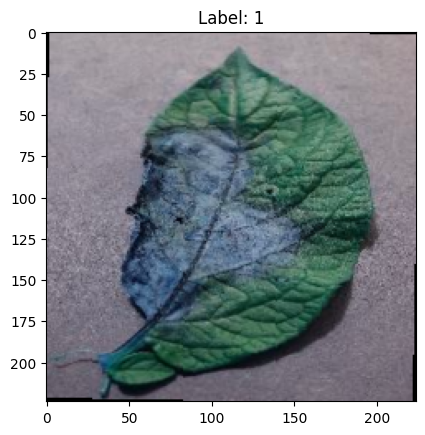

In [10]:
# fetch one batch of data
for images, labels in train_loader:
    # convert the tensor from (C, H, W) to (H, W, C)
    img = images[0].permute(1, 2, 0).cpu().numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) # denormalize
    img = np.clip(img, 0, 1)
    
    
    # Display the image
    plt.imshow(img)
    plt.title(f'Label: {labels[0].item()}')
    plt.show()
    break

# VGG16 Model Definition
****

This part of code defines a custom Pytorch neural module (N_conv). The N_conv class inherits from nn.Module

In [11]:
class N_conv(nn.Module):
    """
    This a class for defining the N convolution
    Attributes
   ----------
    conv: nn.Sequential defines the train model
    """
    def __init__(self,in_channels,out_channels,N = 2):
        super(N_conv,self).__init__()
        
        # Initialize the layers as a list
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), nn.ReLU(True)]
        
        # Add more layers based on the value N
        for i in range(N-1):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), nn.ReLU(True)]
            
        # Add MaxPooling layer
        layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
        
        #Create a Sequential container with the layers
        self.conv = nn.Sequential(*layers)
        
    def forward(self,x):
        # Forward pass through the convolutional layers
        return self.conv(x)

In [12]:
class VGG16(nn.Module):
    """
    This a class for defing the VGG16 model
    Attributes
    ----------
    conv  : nn.Sequential
        defines the train model
    """
    def __init__(self, num_classes=3):
        super(VGG16,self).__init__() # Initialize the nn.Module superclass
        # Define convolutional block
        self.conv1 = N_conv(3,64)          # First block
        self.conv2 = N_conv(64,128)        # Second block
        self.conv3 = N_conv(128,256,N=3)   # Third block , 3 layers
        self.conv4 = N_conv(256,512,N=3)   # Fourth block, 3 layers
        self.conv5 = N_conv(512,512,N=3)   # Fifth block , 3 layers
        # Define the Adaptive Average Pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d((7,7))
        # Difine fully connected layers
        self.fc1 = nn.Linear(512*7*7,4096)
        self.fc2 = nn.Linear(4096,4096)
        self.fc3 = nn.Linear(4096,num_classes)
        self.dropout = nn.Dropout(0.5)     # Dropout for regulization
        self.relu = nn.ReLU(True)          # ReLU activation func-n
        
    def forward(self,x):
        # Pass through each conv block
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)                # Apply Adaptive Average Pooling
        x = torch.flatten(x,1)             # Flatten the output tensor
        x = self.relu(self.fc1(x))         # pass through the first fc layer with ReLU and dropout
        x = self.dropout(x)
        x = self.relu(self.fc2(x))         # pass through the second fc layer with ReLU and dropout
        x = self.dropout(x)
        x = self.fc3(x)                    # pass through the final fc layer
        return x

# Train the Model
******

In [14]:
# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [15]:
# Hyperparameters
learning_rate = 1e-4
num_epochs = 10
num_classes = 3

In [16]:
model_vgg = VGG16(3).to(device)

# Freeze all convolutional layers 
for name, param in model_vgg.named_parameters():
    if 'conv' in name:
        param.requires_grad = False
# Check to ensure only fully connected layers are trainable
for name, param in model_vgg.named_parameters():
    print(f'{name}: {param.requires_grad}')

conv1.conv.0.weight: False
conv1.conv.0.bias: False
conv2.conv.0.weight: False
conv2.conv.0.bias: False
conv3.conv.0.weight: False
conv3.conv.0.bias: False
conv4.conv.0.weight: False
conv4.conv.0.bias: False
conv5.conv.0.weight: False
conv5.conv.0.bias: False
fc1.weight: True
fc1.bias: True
fc2.weight: True
fc2.bias: True
fc3.weight: True
fc3.bias: True


#### Pre-trained VGG-16 model

In [17]:
# model_vgg = models.vgg16(pretrained=True)

# # Freeze all layer 
# for param in model_vgg.parameters():
#     param.requires_grad = False
    
# model_vgg.classifier[6] = nn.Linear(model_vgg.classifier[6].in_features, num_classes)    

# # only the classifier layers will be trainable
# for param in model_vgg.classifier.parameters():
#     param.requires_grad = True
    
# print(model_vgg)

In [19]:
summary(model_vgg, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            N_conv-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 128, 112, 112]          73,856
              ReLU-6        [-1, 128, 112, 112]               0
         MaxPool2d-7          [-1, 128, 56, 56]               0
            N_conv-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         295,168
             ReLU-10          [-1, 256, 56, 56]               0
        MaxPool2d-11          [-1, 256, 28, 28]               0
           N_conv-12          [-1, 256, 28, 28]               0
           Conv2d-13          [-1, 512, 28, 28]       1,180,160
             ReLU-14          [-1, 512,

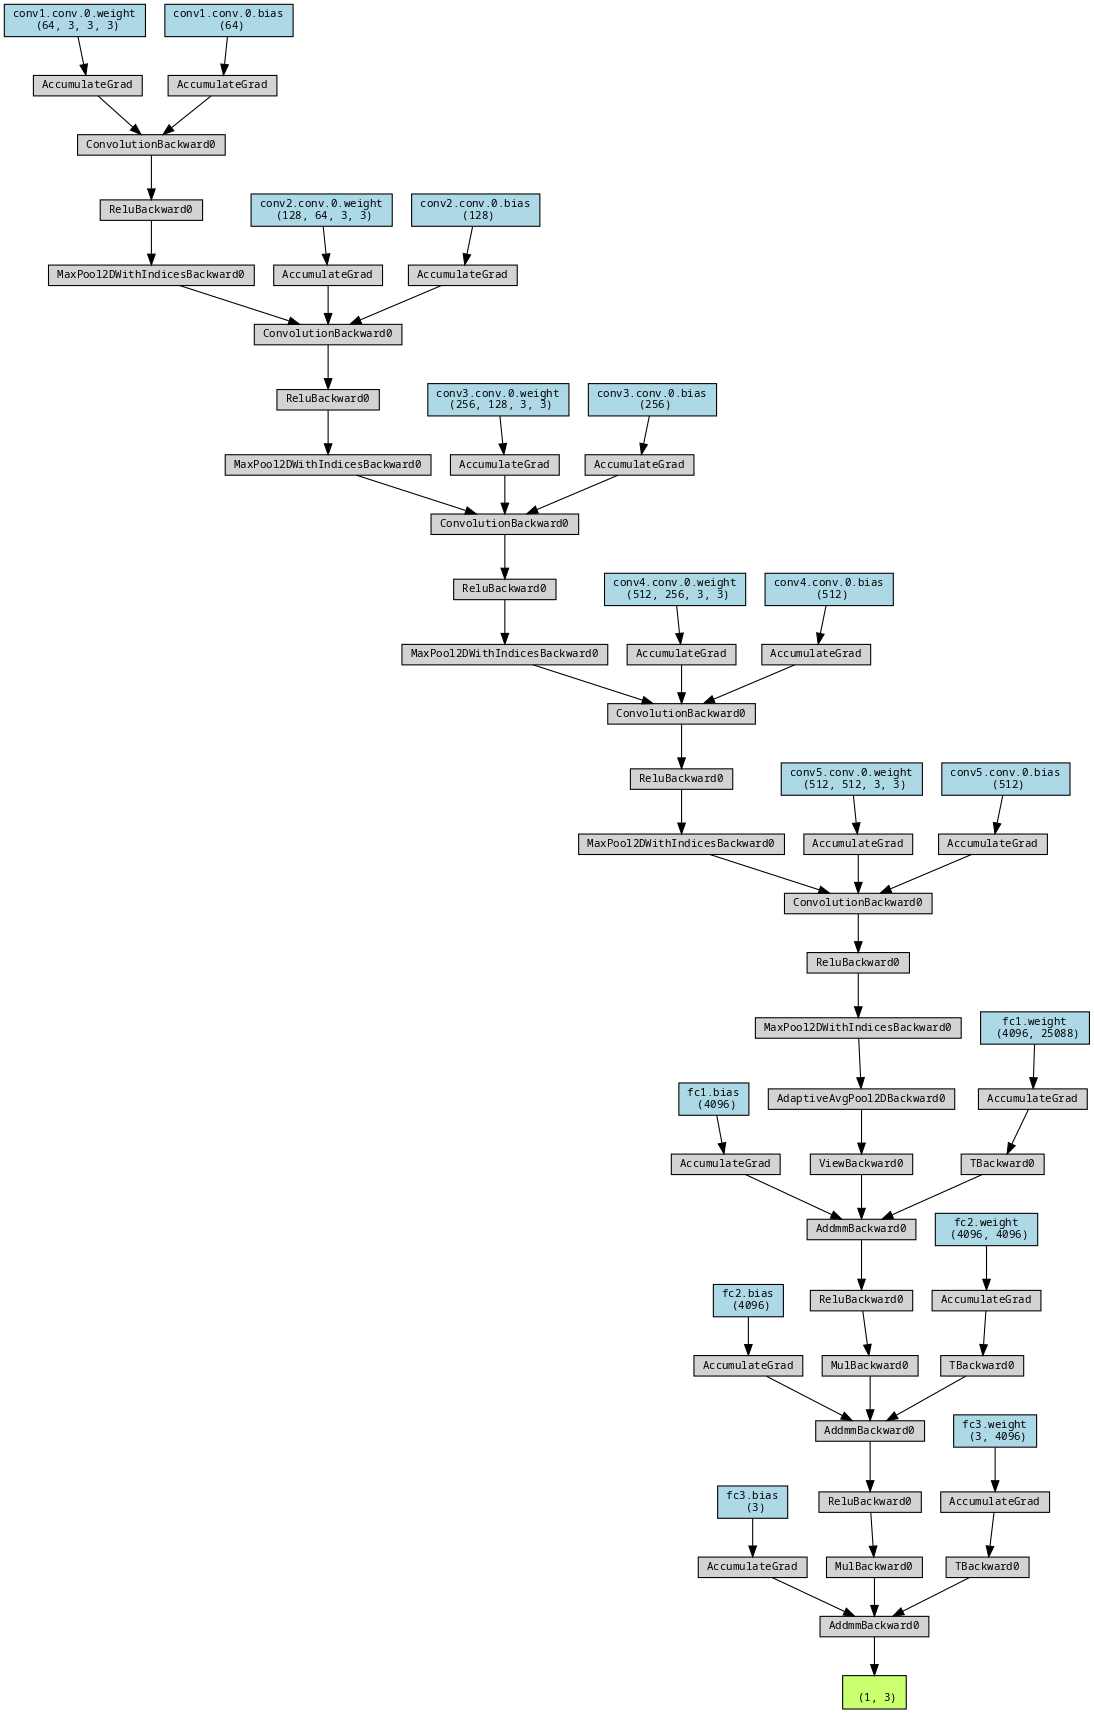

In [20]:
# create sample input tensor 
sample_input = torch.randn(1, 3, 224, 224)
# pass the sammmple input through the model
output = model_vgg(sample_input)

# create a graph
dot = make_dot(output, params=dict(model_vgg.named_parameters()))

#dot.render('vgg16_model', format="png")  #Save the plot as png

# Display 
Image(filename = "vgg16_model.png")

In [21]:
# Define optimazer and loss function 
optimizer = optim.Adam(model_vgg.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [22]:
def train(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    # Initialize empty lists to sore loss and accuracy values for tran and valid datasets
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    # Loop over the specific number of epochs
    for epoch in range(num_epochs):
        
        running_loss = 0.0
        model.train()     # Set the model on trainig mode
        correct_train = 0
        total_train = 0
        # Iterate over the trainig dataset in batches
        for images, labels in train_loader:
            # Move imgs & labels to the device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass: Compute predicted outputs by passing inputs to the model
            outputs = model(images)  
            loss = criterion(outputs, labels) # Compute the loss
            
            # Backward pass and optimization
            optimizer.zero_grad() # clear the gradient of all optimizer param-rs
            loss.backward()       # compute gradients
            optimizer.step()      # update param-rs
            
            # Accumulate the running loss
            running_loss += loss.item() * images.size(0)
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
        # Calculate average training loss and accuracy over the epoch
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss) # Store training loss
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        
        # Validation phase
        model.eval() # set the model to evaluation mode
        val_loss = 0 
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                
                # Forward pass
                outputs = model(images)  
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                
                
                # Calculate accuracy for validation
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                
        # Calculate average validation loss and accuracy
        val_loss /= len(test_loader.dataset)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss) # Store validation loss
        val_accuracies.append(val_accuracy) # Store accuracy

        # Print Epochs statistics
        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, Training Accuracy = {:.2f}, Validation Accuracy: {:.2f}'.format(
            epoch, train_loss, val_loss, train_accuracy, val_accuracy))
        
    return train_losses, val_losses, train_accuracies, val_accuracies # Return the results

In [23]:
# Call the training function
train_losses, val_losses, train_accuracies, val_accuracies = train(model_vgg, train_loader, test_loader, criterion, optimizer, num_epochs)

Epoch: 0, Training Loss: 0.84, Validation Loss: 0.66, Training Accuracy = 0.61, Validation Accuracy: 0.71
Epoch: 1, Training Loss: 0.47, Validation Loss: 0.41, Training Accuracy = 0.84, Validation Accuracy: 0.85
Epoch: 2, Training Loss: 0.39, Validation Loss: 0.39, Training Accuracy = 0.85, Validation Accuracy: 0.85
Epoch: 3, Training Loss: 0.36, Validation Loss: 0.35, Training Accuracy = 0.86, Validation Accuracy: 0.86
Epoch: 4, Training Loss: 0.32, Validation Loss: 0.33, Training Accuracy = 0.88, Validation Accuracy: 0.87
Epoch: 5, Training Loss: 0.28, Validation Loss: 0.29, Training Accuracy = 0.89, Validation Accuracy: 0.88
Epoch: 6, Training Loss: 0.26, Validation Loss: 0.28, Training Accuracy = 0.89, Validation Accuracy: 0.92
Epoch: 7, Training Loss: 0.23, Validation Loss: 0.22, Training Accuracy = 0.91, Validation Accuracy: 0.93
Epoch: 8, Training Loss: 0.20, Validation Loss: 0.19, Training Accuracy = 0.93, Validation Accuracy: 0.93
Epoch: 9, Training Loss: 0.19, Validation Loss

In [30]:
# Save the model
# torch.save(model_vgg.state_dict(), 'vgg16_model.pth')
print("Model saved as vgg16_model.pth")

Model saved as vgg16_model.pth


# Plot the training and validation losses
****

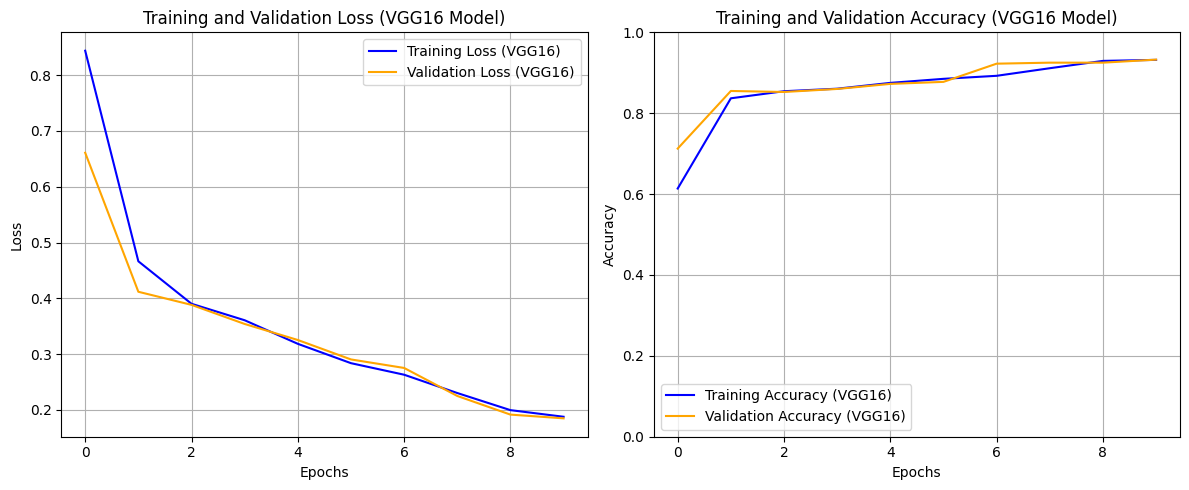

In [25]:
# Set up the figure 
plt.figure(figsize=(12, 5))

# Plotting the training and validation losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss (VGG16)', color='blue')
plt.plot(val_losses, label='Validation Loss (VGG16)', color='orange')
plt.title('Training and Validation Loss (VGG16 Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plotting the validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy (VGG16)', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy (VGG16)', color='orange')
plt.title("Training and Validation Accuracy (VGG16 Model)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1) # set y-axis limits for accuracy
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
# Save as PNG with 300 dpi
#plt.savefig('training_validation_plots.png', format='png', dpi=300)
plt.show()

# Evaluate the data
****

In [26]:
def evaluate_model(model, data_loader, criterion):
    total_loss = 0
    correct = 0
    total = 0
    
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            imageses, labels = images.to(device), labels.to(device)
            
            # Get model outputs
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0) # Accumulate loss

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
                
     # Calculate average validation loss and accuracy
    average_loss = total_loss / len(data_loader.dataset)
    accuracy = correct / total
    return average_loss, accuracy           

In [31]:
# Evaluate on train data
train_loss, train_accuracy = evaluate_model(model_vgg, train_loader, criterion)
print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.3f}')

Train Loss: 0.1393, Train Accuracy: 0.951


In [33]:
# Evaluate on train data
test_loss, test_accuracy = evaluate_model(model_vgg, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.3f}')

Test Loss: 0.1813, Test Accuracy: 0.930


Confusion Matrix (VGG16 Model):
 [[177   7   0]
 [  8 173   0]
 [  0  15  20]]

Classification Report (VGG16 Model):
                        precision    recall  f1-score   support

Potato___Early_blight       0.96      0.96      0.96       184
 Potato___Late_blight       0.89      0.96      0.92       181
     Potato___healthy       1.00      0.57      0.73        35

             accuracy                           0.93       400
            macro avg       0.95      0.83      0.87       400
         weighted avg       0.93      0.93      0.92       400



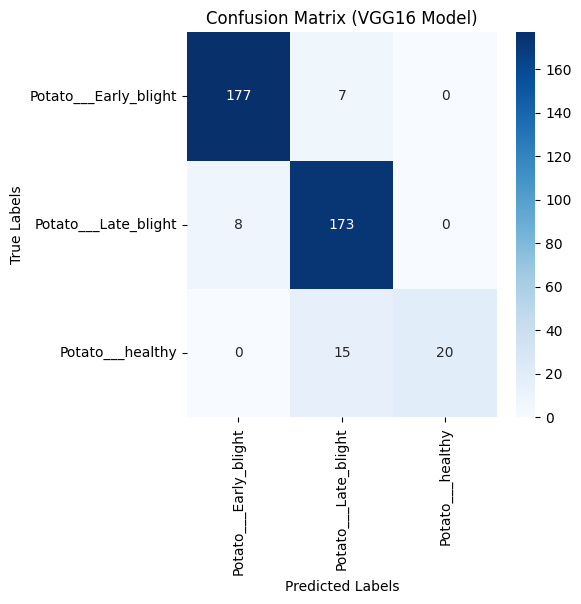

In [29]:
# Generate predictions for the test dataset 
y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_vgg(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        
# Convert to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calculate confusion matrix and classification report
confusion = confusion_matrix(y_true, y_pred)
print('Confusion Matrix (VGG16 Model):\n', confusion)

classes_names = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
report = classification_report(y_true, y_pred, target_names=classes_names)
print('\nClassification Report (VGG16 Model):\n', report)

# Visualize the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues',
            xticklabels=classes_names, yticklabels=classes_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (VGG16 Model)')
# Save as PNG with 300 dpi
#plt.savefig('confusion_matrix.png', format='png', dpi=300)
plt.show()